In [2]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import tinyarray

# Nanoribbon

In [79]:
lat = kwant.lattice.honeycomb(a=1.0, norbs=1)
a, b = lat.sublattices
nnn_hoppings_a = (((-1, 0), a, a), ((0,  1), a, a), ((1, -1), a, a))
nnn_hoppings_b = ((( 1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

t2 = 1e-12  #*tinyarray.array([[1, 0], [0, 1]])
tso = -0.01j#*tinyarray.array([[1, 0], [0, -1]])
t = -1.0    #*tinyarray.array([[1, 0], [0, 1]])

ribbon = kwant.Builder()
ribbon[lat.shape(lambda pos: 0<pos[0]<10 and 0<pos[1]<10, start=[5, 5])]=0*t
ribbon[lat.neighbors(1)]= t
ribbon[lat_neighbors_2] = t2 + tso

rib_lead = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
rib_lead[lat.shape(lambda pos: 0<pos[1]<10, start=[5, 5])]=0*t
rib_lead[lat.neighbors(1)]= t
rib_lead[lat_neighbors_2]=t2 + tso

In [80]:
ribbon.attach_lead(rib_lead)
ribbon.attach_lead(rib_lead.reversed())
print("attached")
fsyst=ribbon.finalized()

attached


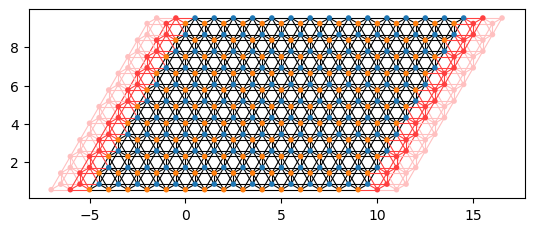

In [81]:
kwant.plot(ribbon)
plt.show()

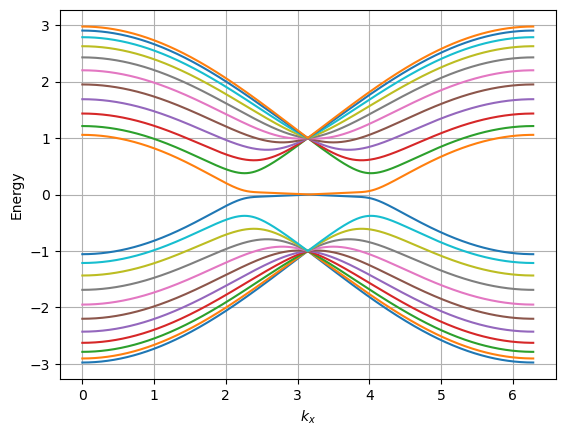

In [82]:
kwant.plotter.bands(rib_lead.finalized(), show=False, momenta=np.linspace(0, 2*np.pi, 1000))
# plt.title("Band structure of the nanoribbon")
plt.xlabel(r"$k_x$")
plt.ylabel("Energy")
plt.grid()
# plt.axhline(0, color='black', lw=0.5)
# plt.axvline(2*np.pi/3, color='red', lw=0.5)
# plt.axvline(-2*np.pi/3, color='red', lw=0.5)
# plt.savefig("band_structure_of_nanoribbon_notitle.pdf", dpi=500)
plt.show()

## wave function of incoming waves

In [83]:
wave_function = kwant.wave_function(sys=fsyst, energy=0.0)

In [84]:
print(wave_function(0).shape)
if wave_function(0).shape[0] > 0:
    psi = wave_function(0)[0]
    psi/=np.linalg.norm(psi)
    print(psi.shape)
    print("Normalized: ", np.allclose(np.sum(np.abs(psi)**2), 1))
else:
    print("wave function is empty")


(1, 330)
(330,)
Normalized:  True


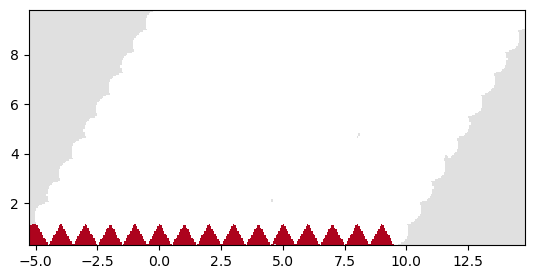

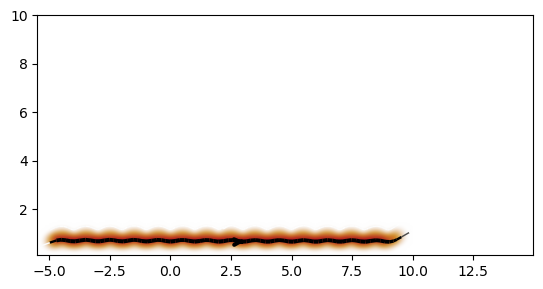

In [87]:
kwant.plotter.map(sys=fsyst, value=np.abs(psi)**2, oversampling=10, colorbar=False)
plt.show()
current_op = kwant.operator.Current(fsyst)
i = current_op(psi)
kwant.plotter.current(fsyst, i, show=False, colorbar=False)
plt.show()

## solving for H(k)

In [7]:
rib_lead = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
rib_lead[lat.shape(lambda pos: 0<pos[1]<20, start=[5, 5])]=0
rib_lead[lat.neighbors(1)]=-1

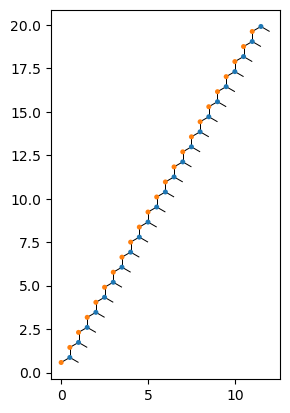

In [8]:
kwant.plot(rib_lead)
plt.show()

In [9]:
rib_lead_f = rib_lead.finalized()

In [10]:
def H(syst:kwant.builder.InfiniteSystem, k):
    H_k = syst.cell_hamiltonian()
    N=len(H_k)
    H_intercell = np.zeros_like(H_k)
    hh = syst.inter_cell_hopping()
    H_intercell[:hh.shape[0], :hh.shape[1]] = hh*np.exp(1j*k)
    H_intercell += np.conj(H_intercell.T)
    H_k += H_intercell
    return H_k

In [11]:
eigen_energies, eigen_states = np.linalg.eigh(H(syst=rib_lead_f, k=2*np.pi/3+0.3))

### Plots

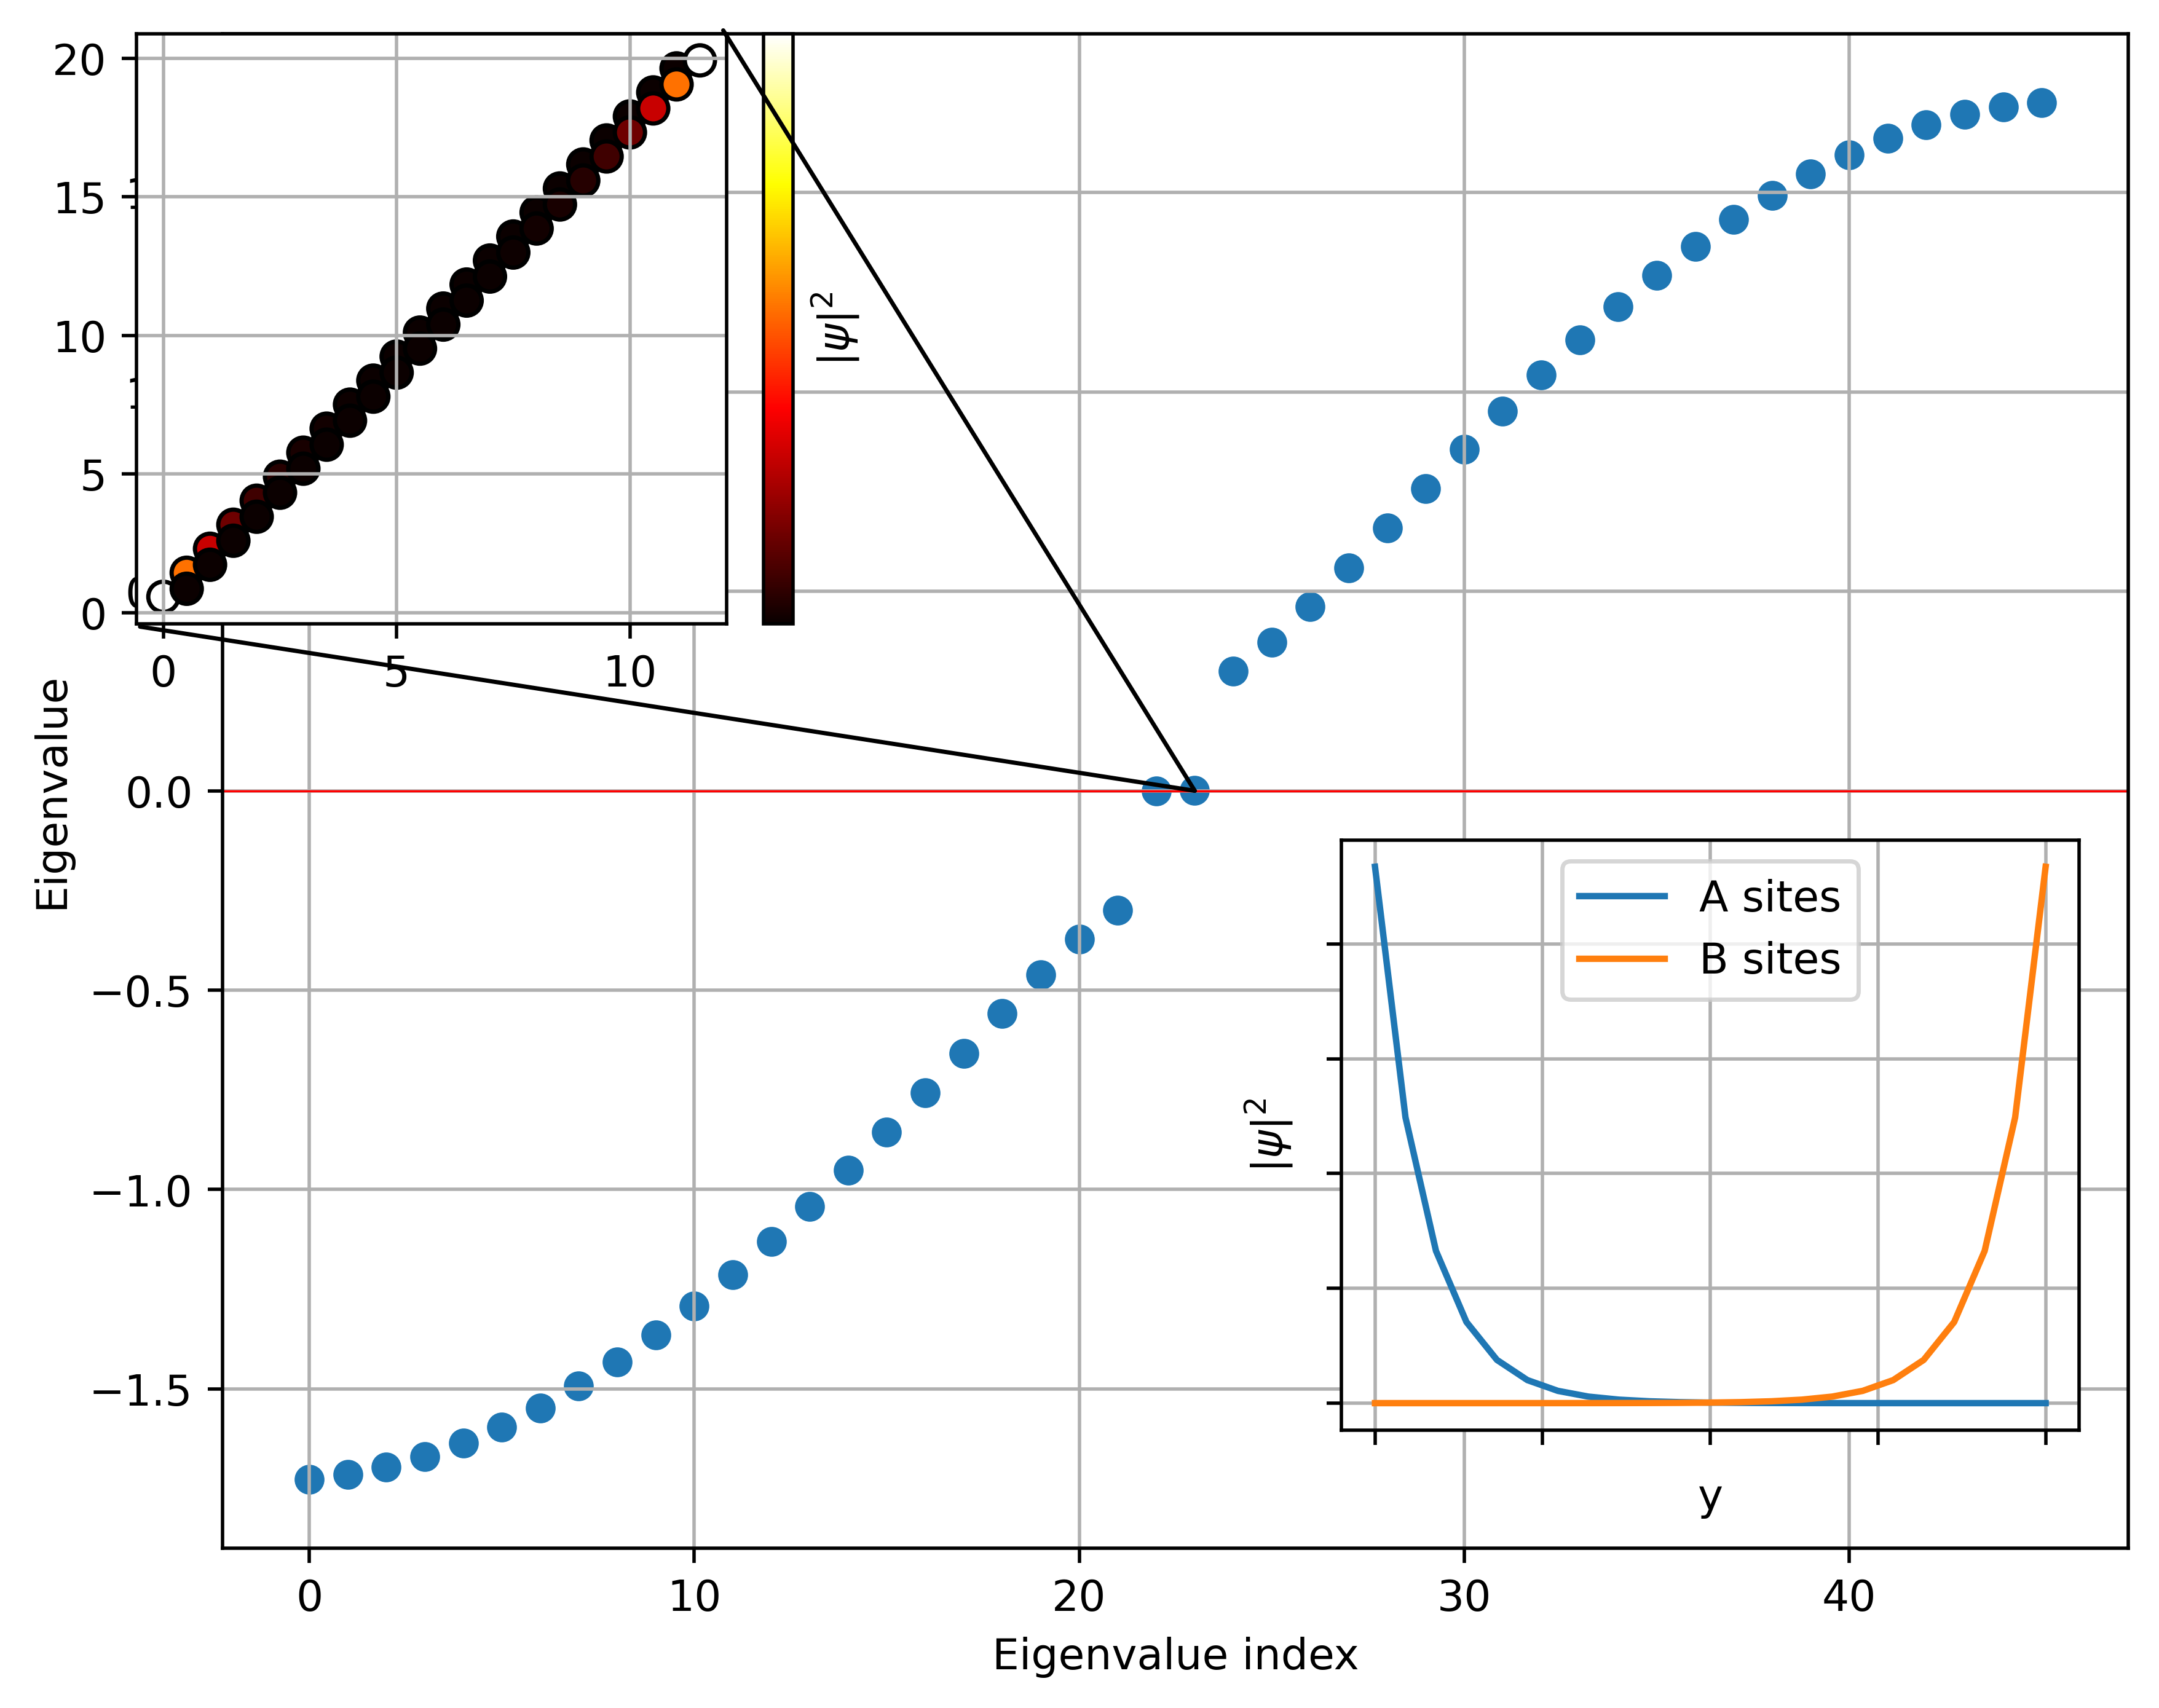

In [ ]:
from matplotlib.patches import ConnectionPatch


fig1, ax1 = plt.subplots(figsize=[8,6.4], dpi=500)
ax1.scatter(range(len(eigen_energies)), eigen_energies)
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
ax1.axhline(0, color='red', lw=0.5)
ax1.grid(True)

ind = 23
sites = list(rib_lead_f.sites)
positions = np.array([site.pos for site in sites])
psi_squared = np.square(np.abs(eigen_states[:, ind]))

inset_ax1 = fig1.add_axes([0.09, 0.58, 0.3, 0.3])
sc = inset_ax1.scatter(positions[:len(psi_squared), 0], positions[:len(psi_squared), 1], c=psi_squared, s=50, cmap='hot', edgecolors='k')
cbr = fig1.colorbar(sc, label=r'$|\psi|^2$', ax=inset_ax1)
cbr.set_ticks([])
# plt.axis('equal')
inset_ax1.grid(True)

inset_ax2 = fig1.add_axes([0.58, 0.17, 0.3, 0.3])
inset_ax2.plot(np.linspace(0,1,len(psi_squared)//2), psi_squared[:len(psi_squared)//2], label="A sites")
inset_ax2.plot(np.linspace(0,1,len(psi_squared)//2), psi_squared[len(psi_squared)//2:], label="B sites")
inset_ax2.set_yticklabels([])
inset_ax2.set_xticklabels([])
inset_ax2.set_xlabel('y')
inset_ax2.set_ylabel(r'$|\psi|^2$')
inset_ax2.legend()
inset_ax2.grid(True)


xy_main = (23, 0.0)
xy_inset = (12, 21)

# Draw arrow from inset to main axes
con = ConnectionPatch(xyA=xy_inset, coordsA=inset_ax1.transData,
                      xyB=xy_main, coordsB=ax1.transData,
                      arrowstyle="-", color="k", lw=1)
con2 = ConnectionPatch(xyA=(-0.5, -0.5), coordsA=inset_ax1.transData,
                      xyB=xy_main, coordsB=ax1.transData,
                      arrowstyle="-", color="k", lw=1)

fig1.add_artist(con)
fig1.add_artist(con2)



# plt.savefig('eigenvalues_H(k)_top.pdf', dpi=400)
plt.show()

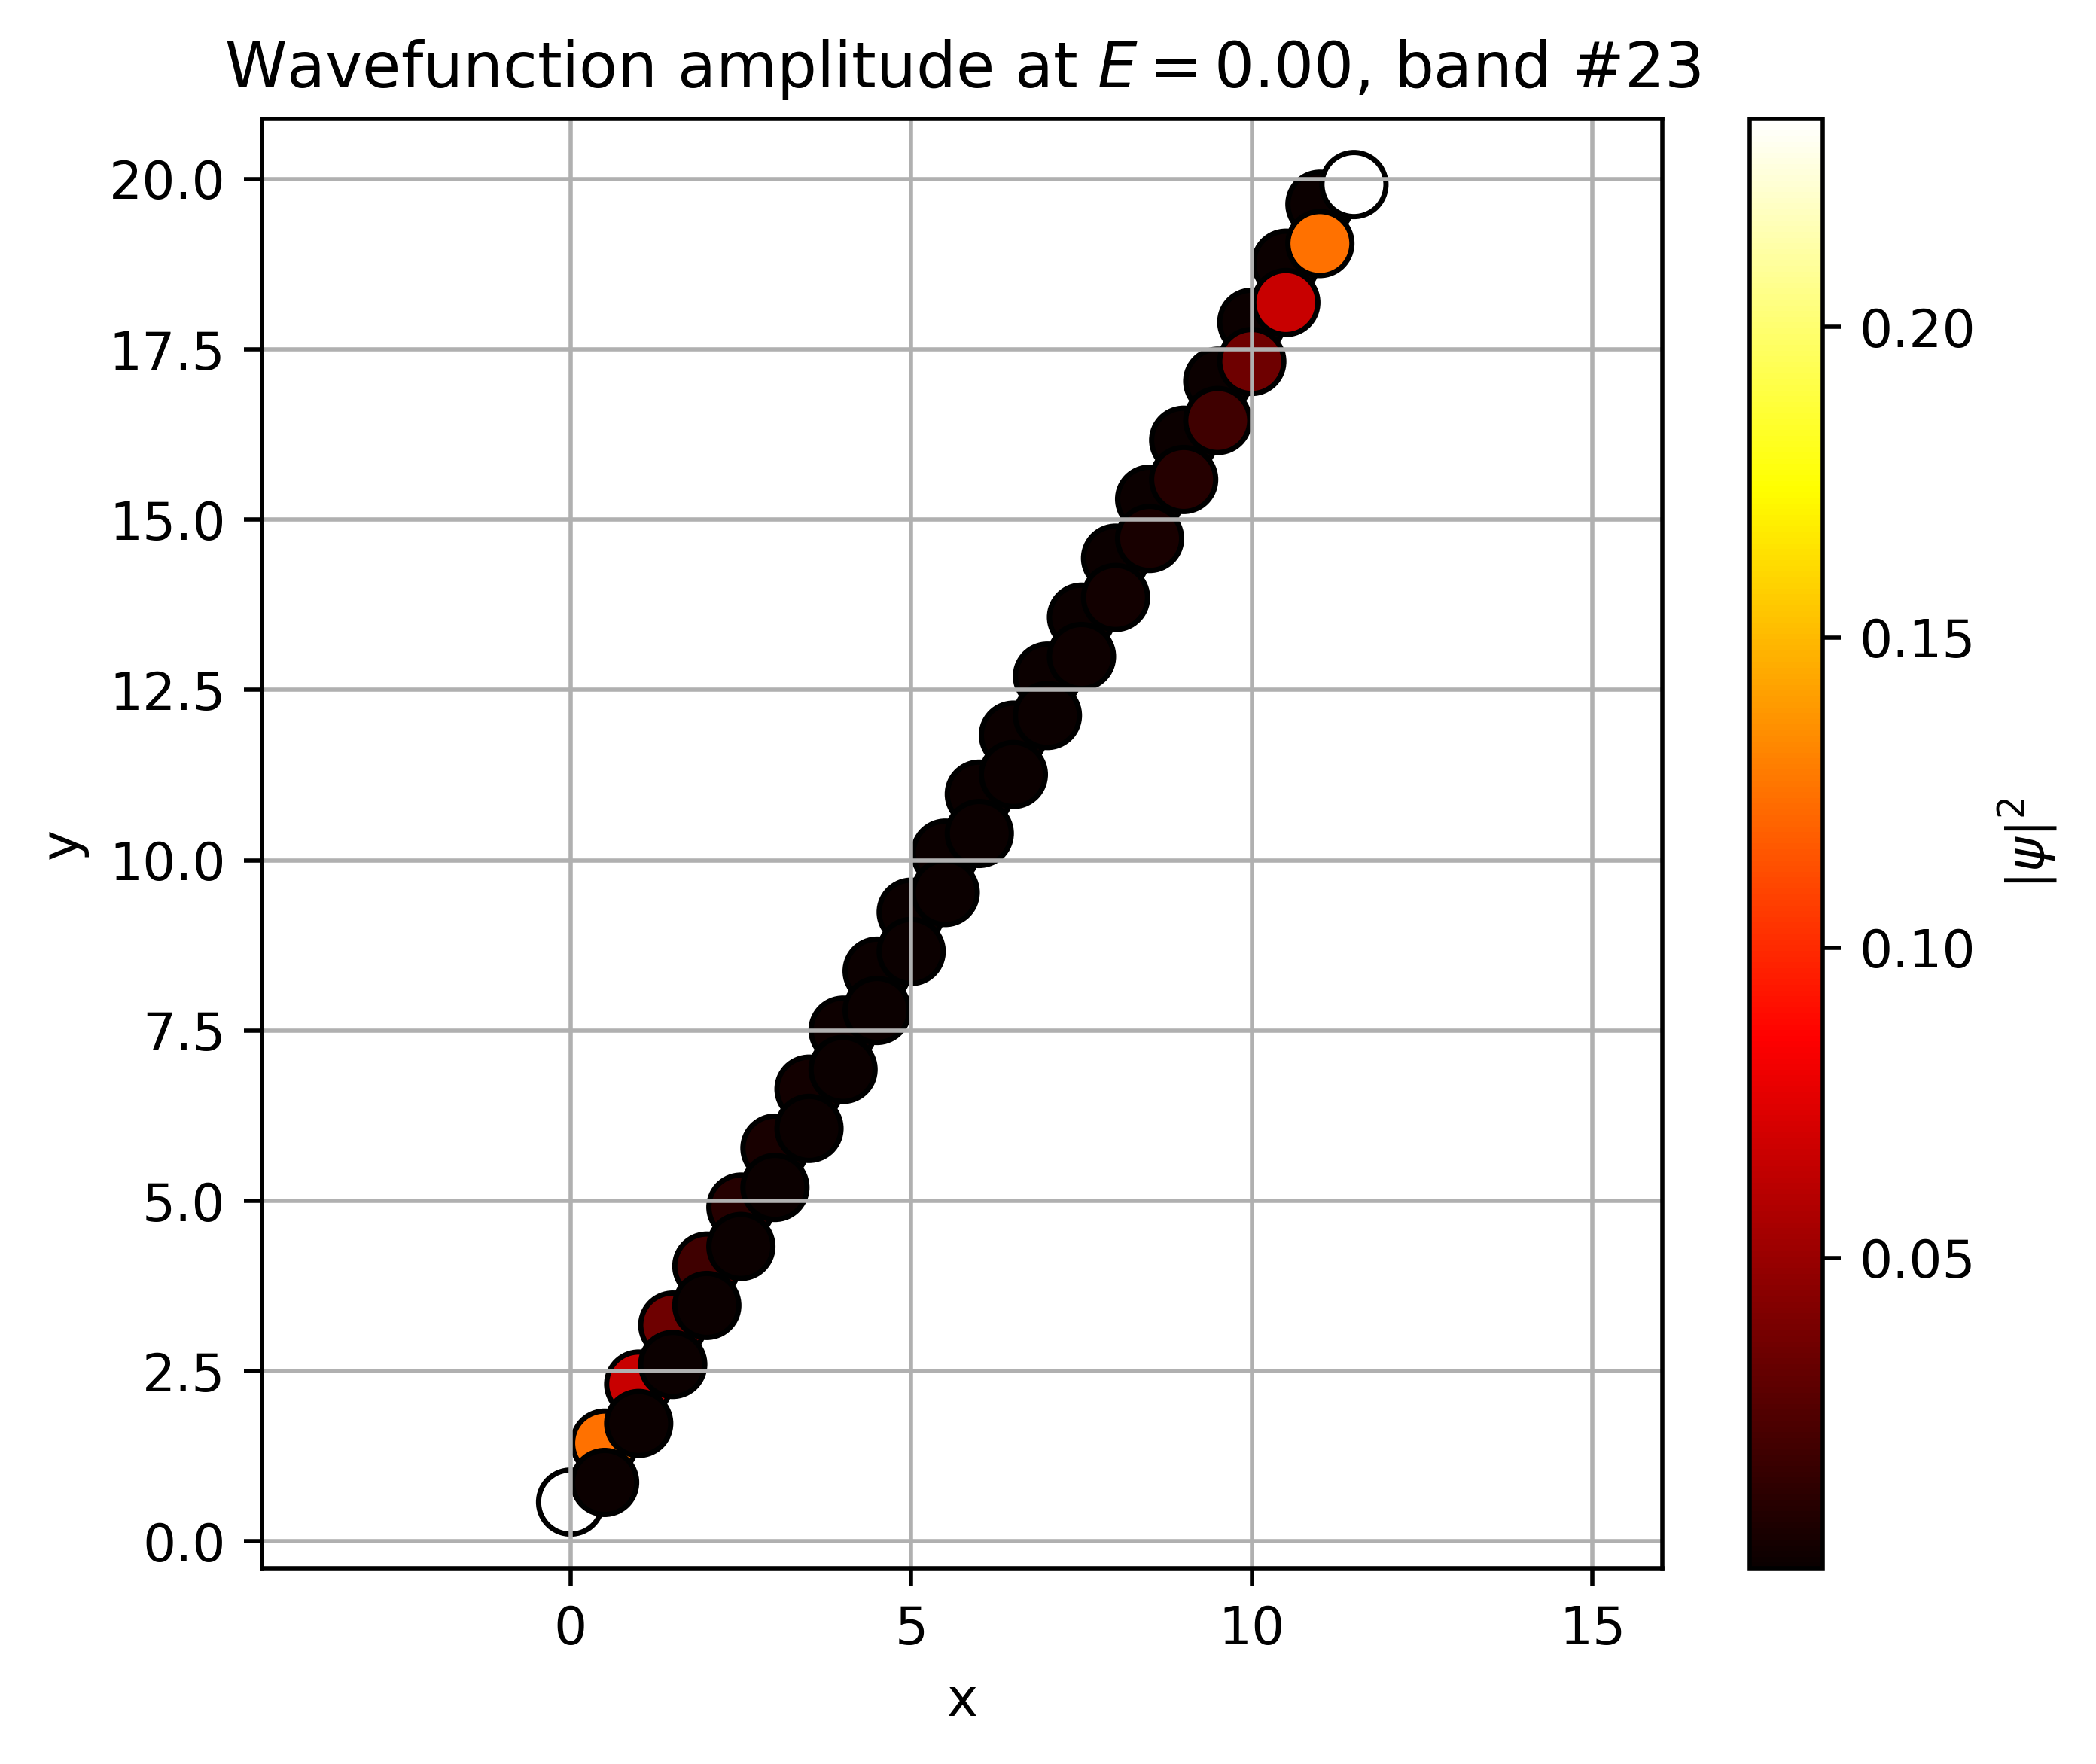

In [65]:
ind = 23
sites = list(rib_lead_f.sites)
positions = np.array([site.pos for site in sites])
psi_squared = np.square(np.abs(eigen_states[:, ind]))

# inset_ax1 = fig1.add_axes([0, 0, 1, 1])
# sc = inset_ax1.scatter(positions[:len(psi_squared), 0], positions[:len(psi_squared), 1], c=psi_squared, s=150, cmap='hot', edgecolors='k')
# plt.colorbar(sc, label=r'$|\psi|^2$')
# plt.title(f'Wavefunction amplitude at $E = {eigen_energies[ind]:.2f}$, band #{ind}')
# plt.axis('equal')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.grid(True)
# # plt.savefig('wavefunction_amplitude_H(k)_triv.png', dpi=400)
# plt.show()

fig2, ax2 = plt.subplots(figsize=[6,5], dpi=500) # type: ignore # type: ignore
sc = ax2.scatter(positions[:len(psi_squared), 0], positions[:len(psi_squared), 1], c=psi_squared, s=150, cmap='hot', edgecolors='k')
# plt.scatter(positions[:len(psi_squared)+1, 0], positions[:len(psi_squared)+1, 1], s=150, cmap='hot', edgecolors='k')

plt.colorbar(sc, label=r'$|\psi|^2$')

plt.title(f'Wavefunction amplitude at $E = {eigen_energies[ind]:.2f}$, band #{ind}')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
# plt.savefig('wavefunction_amplitude_H(k)_triv.png', dpi=400)
plt.show()

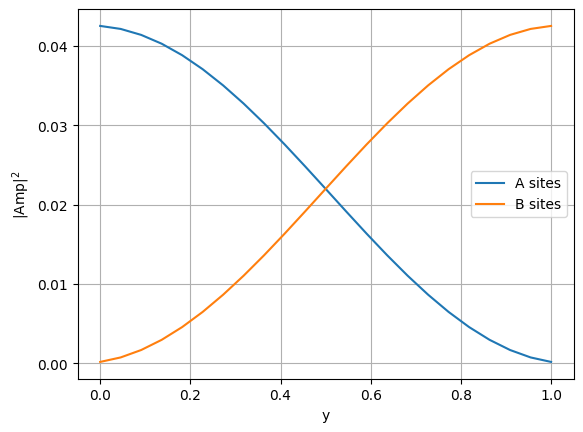

In [62]:
plt.plot(np.linspace(0,1,len(psi_squared)//2), psi_squared[:len(psi_squared)//2], label="A sites")
plt.plot(np.linspace(0,1,len(psi_squared)//2), psi_squared[len(psi_squared)//2:], label="B sites")
plt.xlabel('y')
plt.ylabel(r'$|$Amp$|^2$')
plt.legend()
plt.grid(True)
plt.show()

## Density of states

In [ ]:
spectrum = kwant.kpm.SpectralDensity(fsyst)
# spectrum.add_moments(100)
# spectrum.add_vectors(5)
# spectrum.add_moments(energy_resolution=0.01)

In [ ]:
energies, densities = spectrum()

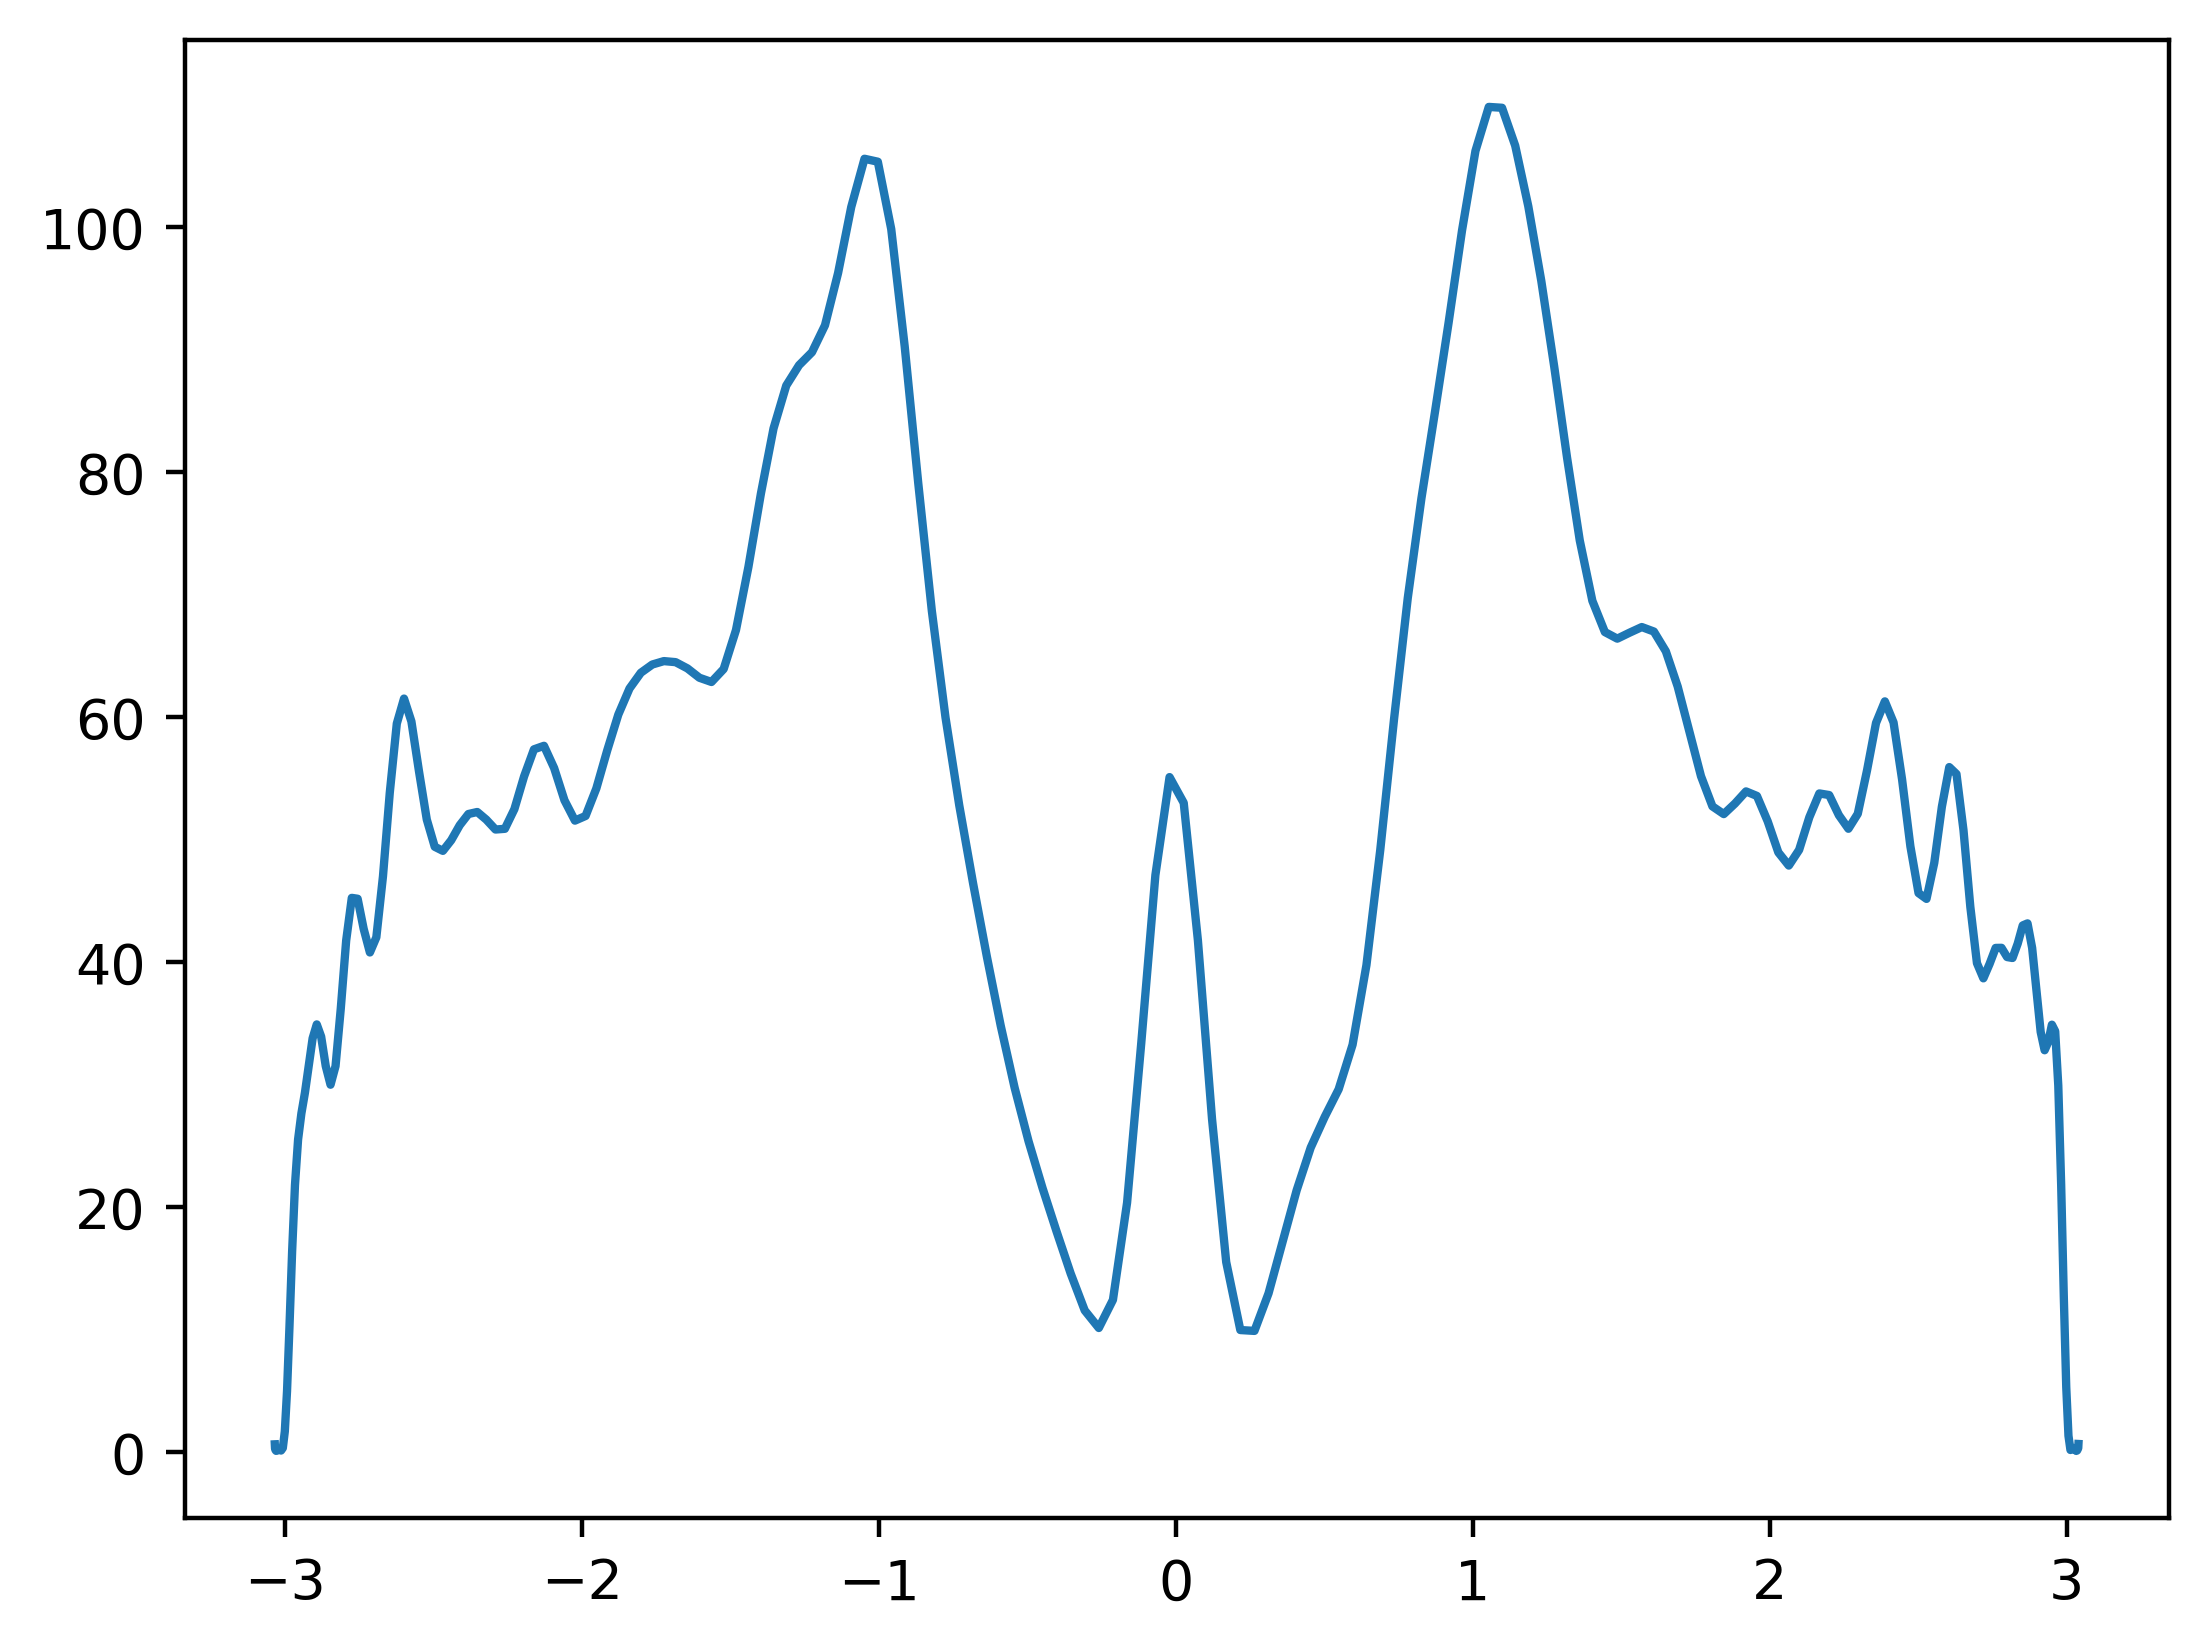

In [ ]:
plt.figure(dpi=400)
plt.plot(energies, np.real(densities))
plt.show()

In [ ]:
# number of states
print('identity resolution:', spectrum.integrate())

identity resolution: (330-9.585951394619787e-32j)


In [ ]:
# number of filled states
# T = 0.01, fermi_energy = 0.0
# fermi = lambda E: 1 / (np.exp((E - 0.0) / 0.01) + 1)

# T = 0.0
def fermi(E):
    f = np.zeros_like(E)
    f[E < 0] = 0
    f[E > 0] = 1
    f[E == 0] =  1/2
    return f

print('number of filled states:', spectrum.integrate(fermi))

number of filled states: (165.11980635067084+6.27714222201563e-16j)


In [ ]:
kwant_op = kwant.operator.Density(fsyst, sum=False)
local_dos = kwant.kpm.SpectralDensity(fsyst, operator=kwant_op)

In [ ]:
zero_energy_ldos = local_dos(energy=-0.1)

# Big dots

In [25]:
def make_syst_topo(r=30, a=1, t=1, t2=0.5):
    syst = kwant.Builder()
    lat = kwant.lattice.honeycomb(a, norbs=1, name=['a', 'b'])

    def circle(pos):
        x, y = pos
        return x ** 2 + y ** 2 < r ** 2

    syst[lat.shape(circle, (0, 0))] = 0.
    syst[lat.neighbors()] = t
    # add second neighbours hoppings
    syst[lat.a.neighbors()] = 1j * t2
    syst[lat.b.neighbors()] = -1j * t2
    syst.eradicate_dangling()

    return lat, syst.finalized()

In [75]:
# construct the Haldane model
lat, fsyst_topo = make_syst_topo(r=160, t2=0)
# find 'A' and 'B' sites in the unit cell at the center of the disk
where = lambda s: np.linalg.norm(s.pos) < 1

# component 'xx'
s_factory = kwant.kpm.LocalVectors(fsyst_topo, where)
cond_xx = kwant.kpm.conductivity(fsyst_topo, alpha='x', beta='x', mean=True,
                                 num_vectors=None, vector_factory=s_factory)
# component 'xy'
s_factory = kwant.kpm.LocalVectors(fsyst_topo, where)
cond_xy = kwant.kpm.conductivity(fsyst_topo, alpha='x', beta='y', mean=True,
                                 num_vectors=None, vector_factory=s_factory)

energies = cond_xx.energies
cond_array_xx = np.array([cond_xx(e, temperature=0.01) for e in energies])
cond_array_xy = np.array([cond_xy(e, temperature=0.01) for e in energies])

# area of the unit cell per site
area_per_site = np.abs(np.cross(*lat.prim_vecs)) / len(lat.sublattices)
cond_array_xx /= area_per_site
cond_array_xy /= area_per_site

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning:

Casting complex values to real discards the imaginary part



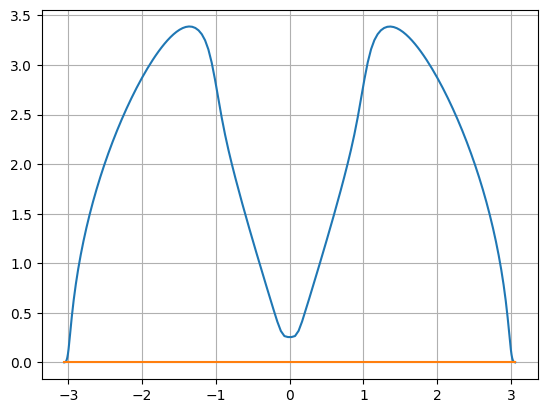

In [76]:
plt.plot(energies, cond_array_xx/4)
plt.plot(energies, cond_array_xy)
plt.grid(True)

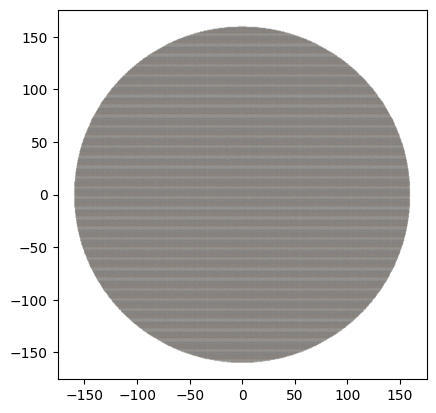

In [77]:
kwant.plot(fsyst_topo)
plt.show()

In [78]:
spect_top = kwant.kpm.SpectralDensity(fsyst_topo)
energies_t, densities_t = spect_top()

In [84]:
# energies_t = np.linspace(-1, 1, 100000)
spect_top.add_moments(energy_resolution=0.001)
spect_top.add_vectors(5)
spect_top.add_moments(100)
densities_t = spect_top(energies_t)

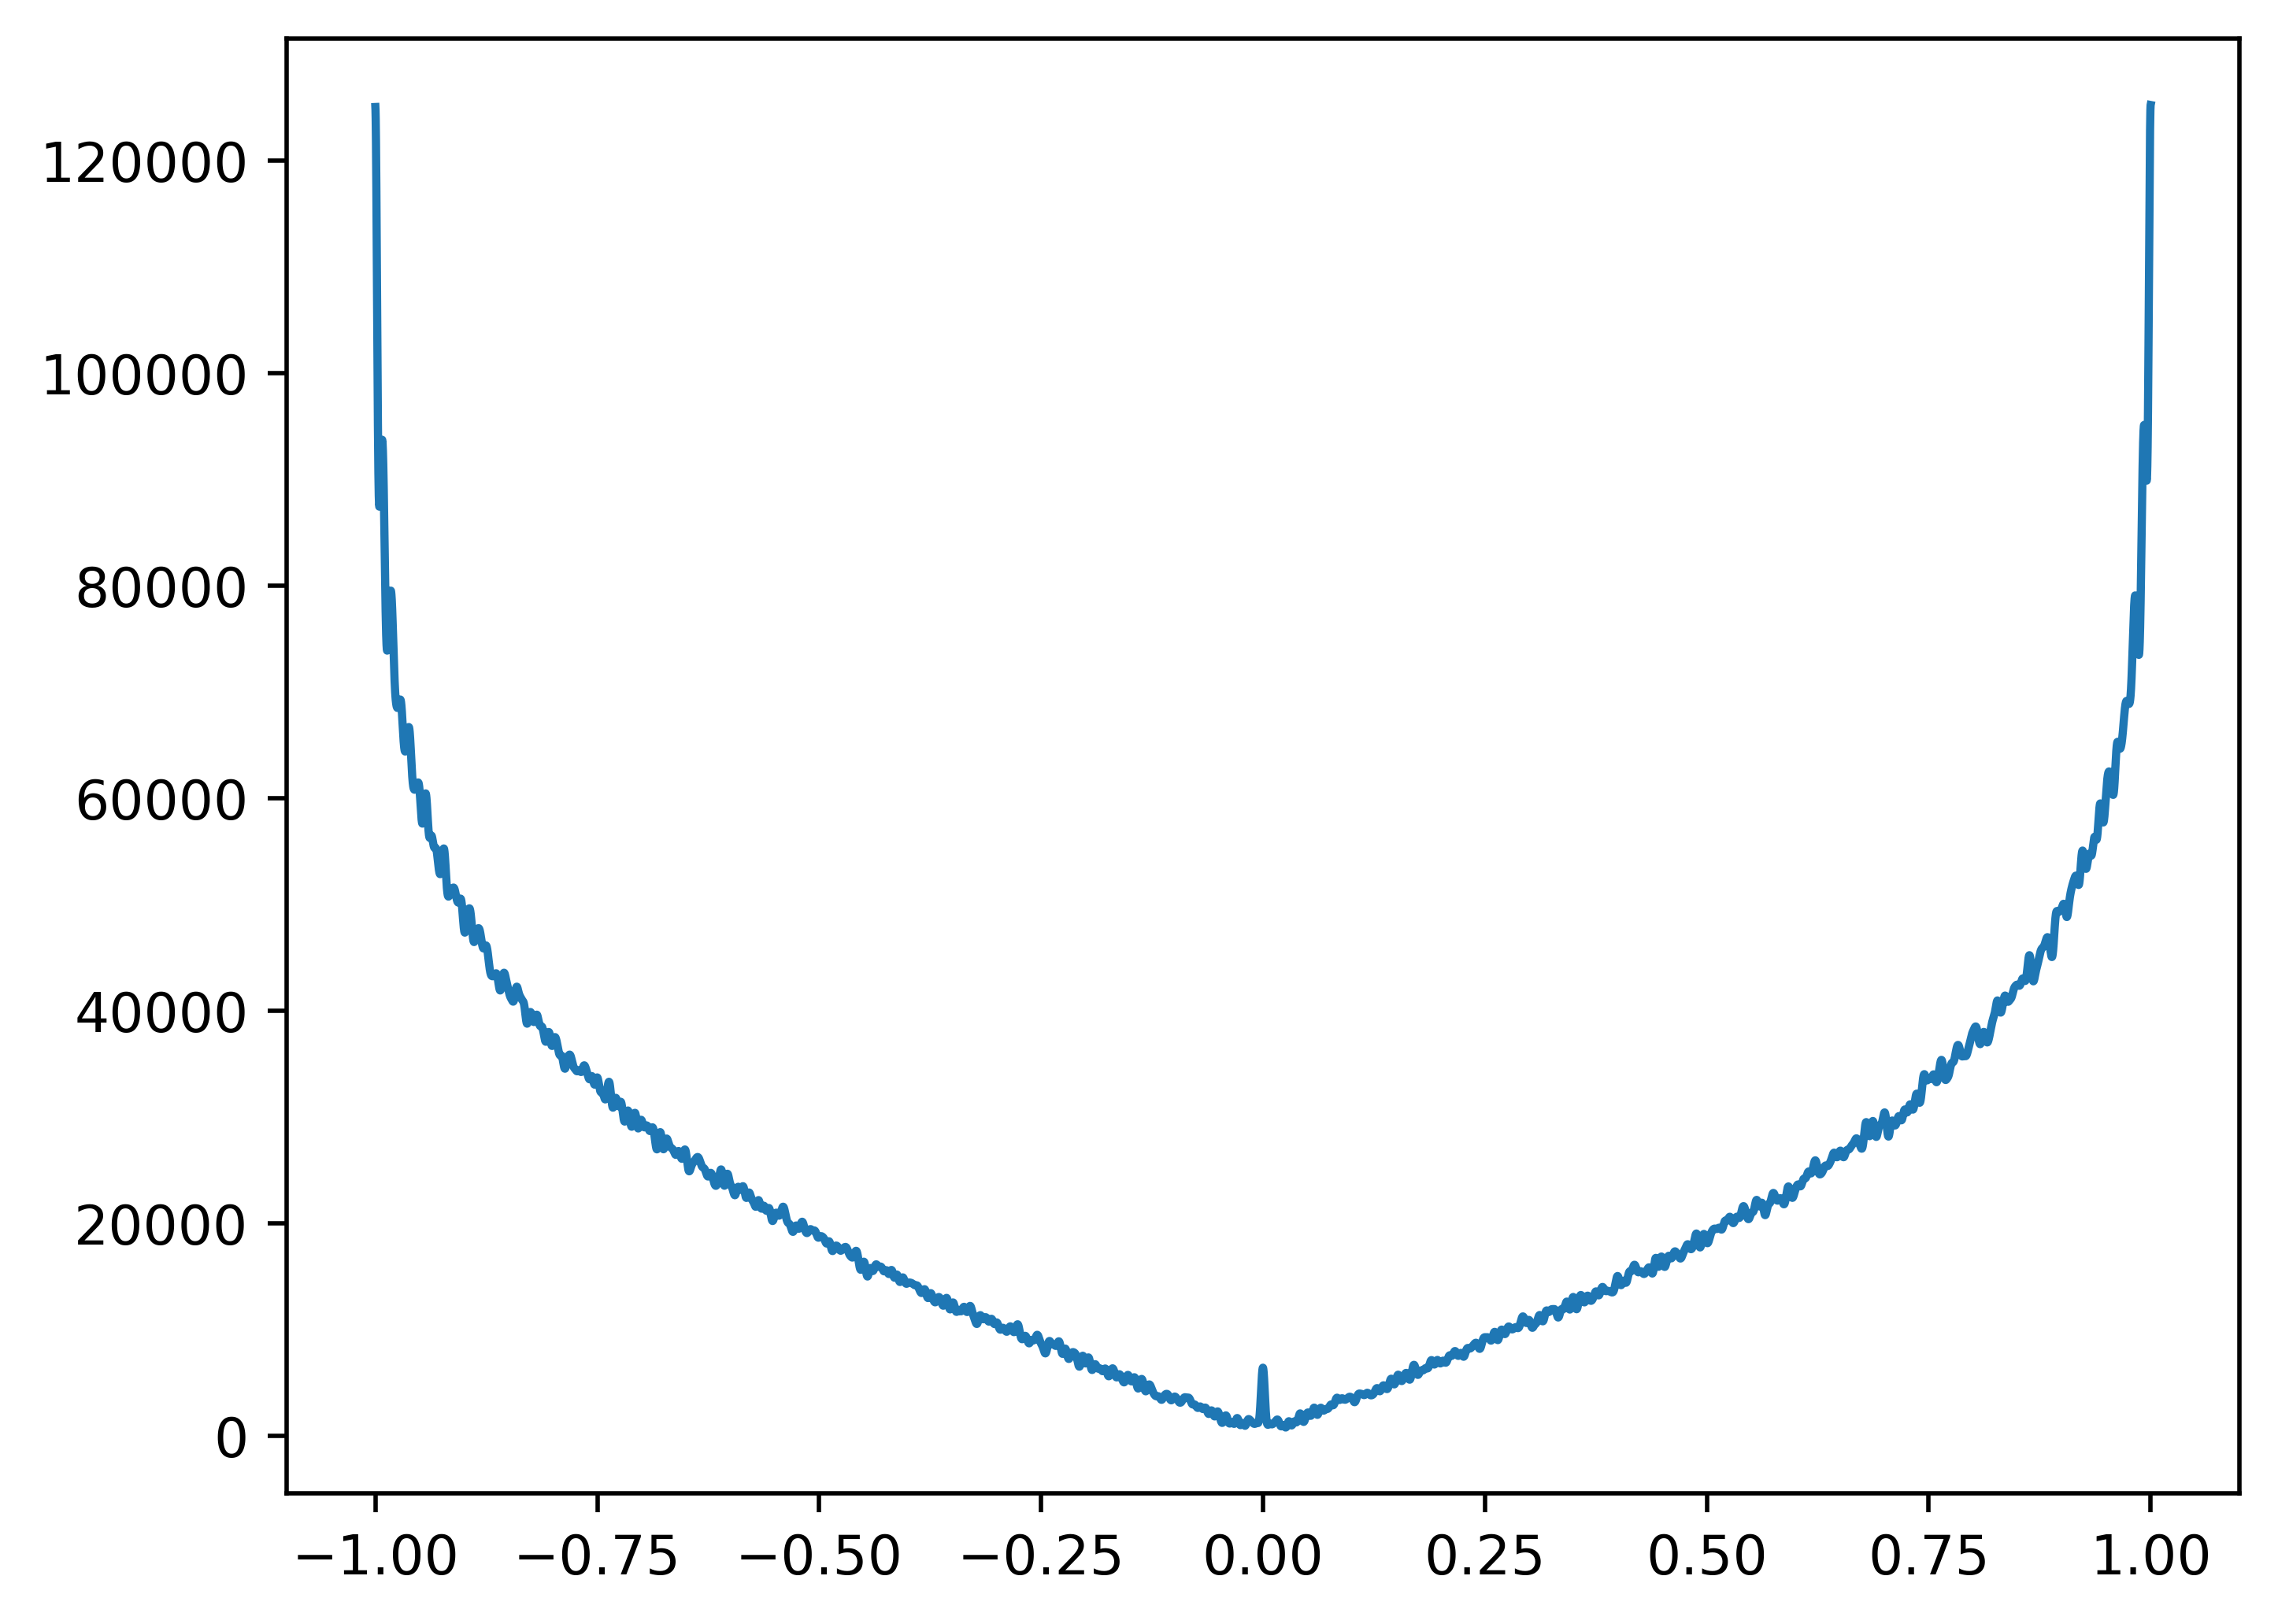

In [85]:
plt.figure(dpi=500)
plt.plot(energies_t, densities_t)
plt.show()

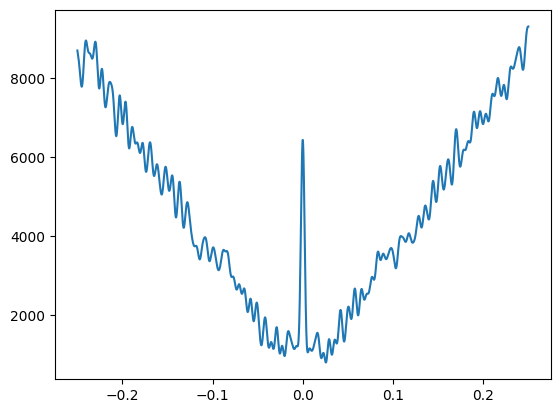

In [90]:
plt.plot(np.linspace(-0.25, 0.25, 10000), spect_top(np.linspace(-0.25, 0.25, 10000)))

In [74]:
len(densities_t)

100000